# 神经网络的训练

作者：杨岱川

时间：2019年12月

github：https://github.com/DrDavidS/basic_Machine_Learning

开源协议：[MIT](https://github.com/DrDavidS/basic_Machine_Learning/blob/master/LICENSE)

参考文献：

- 《深度学习入门》，作者：斋藤康毅；
- 《深度学习》，作者：Ian Goodfellow 、Yoshua Bengio、Aaron Courville。
- [Keras overview](https://tensorflow.google.cn/guide/keras/overview)

## 本节目的

在[3.01 神经网络与前向传播](https://github.com/DrDavidS/basic_Machine_Learning/blob/master/深度学习基础/3.01%20神经网络与前向传播.ipynb)中我们学习了基于多层感知机的神经网络前向传播的原理，并且动手实现了一个很简单的神经网络模型。

但是，目前为止我们搭建的神经网络的权重矩阵 $W$ 是随机初始化的，我们只能说把输入 $X$ “喂”了进去， 然后“跑通”了这个网络。但是它的输出并没有任何实际的意义，因为我们并没有对它进行训练。

在 3.02 教程中，我们的主题就是**神经网络的学习**，也就是我们的神经网络是如何从训练数据中自动获取最优权重参数的过程，这个过程的主要思想和之前在传统机器学习中描述的训练本质相同。

我们为了让神经网络能够进行学习，将导入**损失函数（loss function）**这一指标，相信大家对其并不陌生。

神经网络学习的目的就是以损失函数为基准，找出能够使它的值达到最小的权重参数。而为了找出尽可能小的损失函数的值，我们将采用**梯度法**。

> 这些名词是不是听起来都很熟悉？  
>
>“梯度法”在[2.11 XGBoost原理与应用](https://github.com/DrDavidS/basic_Machine_Learning/blob/master/机器学习基础/2.11%20XGBoost原理与应用.ipynb)中以**梯度提升**的形式出现，而“损失函数”更是贯穿了整个传统机器学习过程。

## 从数据中学习

同其他机器学习算法一样，神经网络的特征仍然是可以从数据中学习。什么叫“从数据中学习”，就是说我们的权重参数可以由数据来自动决定。

既然是机器学习，我们当然不能人工地决定参数，这样怎么忙得过来呢？

>一些大型神经网络参数数量，当然参数更多不代表效果一定更好：
>
>- ALBERT：1200万，by 谷歌；
>- BERT-large：3.34亿，by 谷歌；
>- BERT-xlarge：12.7亿，by 谷歌；
>- Megatron：80亿，by Nvidia；
>- T5，110亿，by 谷歌。

接下来我们会介绍神经网络地学习，也就是如何利用数据决定参数值。

## 损失函数

损失函数地概念大家都熟悉，我们在之前学过非常多的损失函数，比如 0-1 损失函数，均方误差损失函数等。这里我们会再介绍一种新的损失函数。

### 交叉熵误差

**交叉熵误差（cross entropy error）**是一种非常常用的损失函数，其公式如下：

$$\large E=-\sum_k t_k\log y_k$$

其中，$\log$ 是以 $\rm e$ 为底数的自然对数 $\log_e$。$k$ 表示共有 $k$ 个类别。$y_k$ 是神经网络的输出，$t_k$ 是真实的、正确的标签。$t_k$ 中只有正确解的标签索引为1，其他均为0，注意这里用的是 one-hot 表示，所以接受多分类问题。

实际上这个公式只计算了正确解标签输出的自然对数。

比如，一个三分类问题，有 A, B ,C 三种类别，而真实值为C，即 $t_k=[0,\quad0,\quad1]$，

而神经网络经过 softmax 后的输出 $y_k=[0.1,\quad0.3,\quad0.6]$。所以其交叉熵误差为 $-\log0.6\approx0.51$。

我们用代码来实现交叉熵：

In [1]:
import numpy as np

In [2]:
def cross_entropy_error(y, t):
    """定义交叉熵损失函数"""
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

这里的 $y$ 和 $t$ 都是 NumPy 数组。我们在计算 `np.log` 的时候加上了一个很小的值 delta，是为了防止出现 `np.log(0)` 的情况，也就是返回值为负无穷。这样一来会导致后续计算无法进行。

接下来我们试试使用代码进行简单的计算：

In [3]:
# 设置第三类为正确解
t = np.array([0, 0, 1])
t

array([0, 0, 1])

In [4]:
# 设置三类概率情况，y1
y1 = np.array([0.1, 0.3, 0.6])
y1

array([0.1, 0.3, 0.6])

In [5]:
# 设置三类概率情况，y2
y2 = np.array([0.3, 0.4, 0.3])
y2

array([0.3, 0.4, 0.3])

In [6]:
# 计算y1交叉熵
cross_entropy_error(y1, t)

0.510825457099338

In [7]:
# 计算y2交叉熵
cross_entropy_error(y2, t)

1.2039724709926583

可以看出第一个输出 y1 与监督数据（训练数据）更为切合，所以交叉熵误差更小。

### mini-batch 学习

机器学习使用训练数据进行学习，我们对训练数据计算损失函数的值。找出让这个值尽可能小的参数。也就是说，计算损失函数的时候必须将所有的训练数据作为对象，有 100 个数据，就应当把这 100 个损失函数的总和作为学习的目标。

要计算所有训练数据的损失函数的综合，以交叉熵误差为例：

$$\large E=-\frac{1}{N}\sum_n \sum_k t_{nk}\log y_{nk}$$

虽然看起来复杂，其实只是把单个数据的损失函数扩展到了 $n$ 个数据而已，最后再除以 $N$，求得单个数据的“平均损失函数”。这样平均化以后，可以获得和训练数据的数量无关的统一指标。

问题在于，很多数据集的数据量可不少，以 MNIST 为例，其训练数据有 60000 个，如果以全部数据为对象求损失函数的和，则时间花费较长。如果更大的数据集，比如 [ImageNet](http://www.image-net.org/about-stats) 数据集，甚至有1419万张图片（2019年12月），这种情况下以全部数据为对象计算损失函数是不现实的。

因此，我们从全部数据中选出一部分，作为全部数据的“近似”。神经网络的学习也是从训练数据中选出一批数据（mini-batch，小批量），然后对每个mini-batch进行学习。

比如在 MNIST 数据集中，每次选择 100 张图片学习。这种学习方式称为 **mini-batch学习**。或者说，整个训练过程的 batch-size 为 100。

### 为何要设定损失函数

为什么我们训练过程是损失函数最小？我们的最终目的是提高神经网络的识别精度，为什么不把识别精度作为指标？

这涉及到导数在神经网络学习中的作用。以后会详细解释，在神经网络的学习中，寻找最优参数（权重和偏置）时，要寻找使得损失函数的值尽可能小的的参数。而为了找到让损失函数值尽可能小的地方，需要计算参数的导数（准确说是**梯度**），然后以这个导数为指引，逐步更新参数的值。

假设有一个神经网络，我们关注这个网络中某一个权重参数。现在，对这个权重参数的损失函数求导，表示的是“如果稍微改变这个权重参数的值，损失函数会怎么变化”。如果导数的值为负，通过使该权重参数向正方向改变，可以减小损失函数的值；反过来，如果导数的值为正，则通过使该权重参数向负方向改变，可以减小损失函数的值。

>如果导数的值为 0 时，无论权重参数向哪个方向变化，损失函数的值都不变。

如果我们用识别精度（准确率）作为指标，那么绝大多数地方的导数都会变成 0 ，导致参数无法更新。

>假设某个神经网络识别出了 100 个训练数据中的 32 个，这时候准确率为 32%。如果我们以准确率为指标，即使稍微改变权重参数的值，识别的准确率也将继续保持在 32%，不会有变化。也就是说，仅仅微调参数，是无法改善识别精度的。即使有所改善，也不会变成 32.011% 这样连续变化，而是变成 33%，34% 这样离散的值。
>
>而如果我们采用**损失函数**作为指标，则当前损失函数的值可以表示为 0.92543...之类的值，而稍微微调一下参数，对应损失函数也会如 0.93431... 这样发生连续的变化。

所以，识别精度对微小的参数变化基本没啥反应，即使有反应，它的值也是不连续地、突然地变化。

回忆之前学习的 **阶跃函数** 和 **sigmoid 函数**：

In [13]:
import matplotlib
print(matplotlib.__version__)

3.1.1


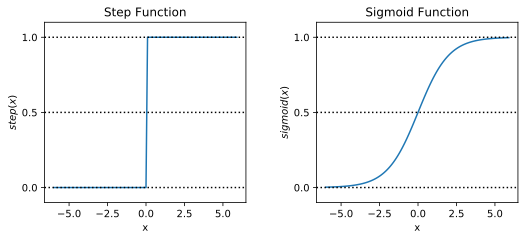

In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'  # 生成矢量图

def sigmoid(x):
    """定义sigmoid函数"""
    return 1.0/(1.0 + np.exp(-x))

def step_function(x):
    """定义阶跃函数"""
    return np.array(x > 0, dtype=np.int)

# 阶跃函数
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
x = np.arange(-6.0, 6.0, 0.1)
plt.plot(x, step_function(x))
plt.axhline(y=0.0,ls='dotted',color='k')
plt.axhline(y=1.0,ls='dotted',color='k')
plt.axhline(y=0.5,ls='dotted',color='k')
plt.yticks([0.0,0.5,1.0])
plt.ylim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('$step(x)$')
plt.title('Step Function')
# plt.savefig("pic001.png", dpi=600)  # 保存图片

# sigmoid 函数
plt.subplot(1, 2, 2)
plt.plot(x, sigmoid(x))
plt.axhline(y=0.0,ls='dotted',color='k')
plt.axhline(y=1.0,ls='dotted',color='k')
plt.axhline(y=0.5,ls='dotted',color='k')
plt.yticks([0.0,0.5,1.0])
plt.ylim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('$sigmoid(x)$')
plt.title('Sigmoid Function')
# plt.savefig("pic001.png", dpi=600)  # 保存图片
plt.tight_layout(3)  # 间隔
plt.show()

如果我们使用**阶跃函数**作为激活函数，神经网络的学习无法进行。如图，阶跃函数的导数在绝大多数的地方都是 0 ，也就是说，如果我们采用阶跃函数，那么即使将损失函数作为指标，参数的微小变化也会被阶跃函数抹杀，导致损失函数的值没有任何变化。

而 **sigmoid 函数**，如图，不仅函数的输出是连续变化的，曲线的斜率也是连续变化的。也就是说，sigmoid 函数的导数在任何地方都不为 0。得益于这个性质，神经网络的学习得以正确进行。

## 数值微分

我们使用梯度信息决定前进方向。现在我们会介绍什么是梯度，它有什么性质。

### 导数

相信大家对导数都不陌生。导数就是表示某个瞬间的变化量，定义为：

$$\large \frac{{\rm d}f(x)}{{\rm d}x} = \lim_{h\to 0}\frac{f(x+h)-f(x)}{h}$$

那么现在我们参考上式实现函数求导：

In [9]:
def numerical_diff(f, x):
    """不太好的导数实现"""
    h = 1e-50
    return (f(x + h) - f(x)) / h

`numerical_diff` 的命名来源于 **数值微分（numerical differentiation）**。

实际上，我们对 $h$ 赋予了一个很小的值，反倒产生了**舍入误差**：

In [10]:
np.float32(1e-50)

0.0

如果采用 `float32` 类型来表示 $10^{-50}$，就会变成 $0.0$，无法正确表示。这是第一个问题，我们应当将微小值 $h$ 改为 $10^{-4}$，就可以得到正确的结果了。

第二个问题和函数 $f$ 的差分有关。我们虽然实现了计算函数 $f$ 在 $x+h$ 和 $x$ 之间的差分，但是是有误差的。我们实际上计算的是点 $x+h$ 和 $x$ 之间连线的斜率，而真正的导数则是函数在 $x$ 处切线的斜率。出现这个差异的原因是因为 $h$ 不能真的无限接近于 0。

为了减小误差，我们计算函数 $f$ 在 $(x+h)$ 和 $(x-h)$ 之间的差分。因为这种计算方法以 $x$ 为中心，计算左右两边的差分，所以叫**中心差分**，而 $(x+h)$ 和 $x$ 之间的差分叫**前向差分**。

现在改进如下：

In [11]:
def numerical_diff(f, x):
    """改进后的导数实现"""
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2 * h)

### 数值微分的例子

使用上面的数值微分函数对简单函数求导：

$$\large y=0.01x^2+0.1x$$

首先我们绘制这个函数的图像。

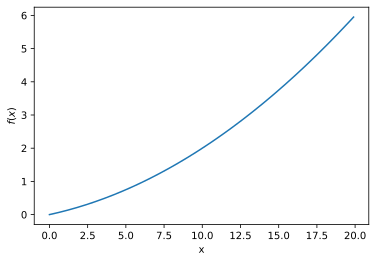

In [12]:
def function_1(x):
    """定义函数"""
    return 0.01 * x**2 + 0.1*x

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel('x')
plt.ylabel('$f(x)$')
plt.plot(x, y)
plt.show()

计算函数在 $x=5$ 时候的导数，画切线：

0.1999999999990898


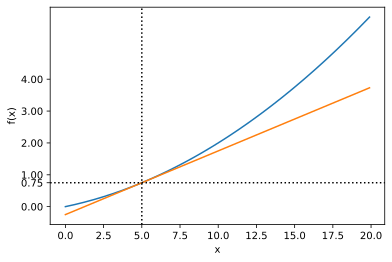

In [13]:
def tangent_line(f, x):
    """切线"""
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.axvline(x=5,ls='dotted',color='k')
plt.axhline(y=0.75,ls='dotted',color='k')
plt.yticks([0, 0.75, 1, 2, 3, 4])
plt.show()

众所周知，$f(x)=0.01x^2+0.1x$ 求导的解析解是 $\cfrac{{\rm d}f(x)}{{\rm d}x}=0.02x+0.1$，因此在 $x=5$ 的时候，“真的导数”为 0.2。和上面的结果比起来，严格来说不一致，但是误差很小。

### 偏导数

接下来我们看一个新函数，这个函数有两个变量：

$$\large f(x_0, x_1)=x_0^2+x_1^2$$

其图像的绘制，用代码实现就是如下：

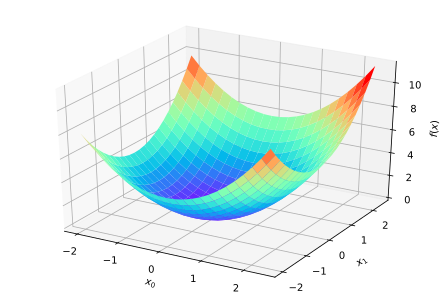

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import numpy as np

def function_2_old(x_0, x_1):
    """二元函数"""
    return x_0**2 + x_1**2



fig = plt.figure()
ax = Axes3D(fig)

x_0 = np.arange(-2, 2.5, 0.2)  # x0 
x_1 = np.arange(-2, 2.5, 0.2)  # x1
X_0, X_1 = np.meshgrid(x_0, x_1)  # 二维数组生成
Y = function_2_old(X_0, X_1)

ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$f(x)$')

ax.plot_surface(X_0, X_1, Y, rstride=1, cstride=1, cmap='rainbow')
# ax.view_init(30, 60)  # 调整视角
plt.show()

很漂亮的一幅图。

如果我们要对这个二元函数求导，就有必要区分是对 $x_0$ 还是 $x_1$ 求导。

这里讨论的有多个变量函数的导数就是**偏导数**，表示为 $\cfrac{\partial f}{\partial x_0}$、$\cfrac{\partial f}{\partial x_1}$。

当 $x_0=3$，$x_1=4$ 的时候，求关于 $x_0$ 的偏导数$\cfrac{\partial f}{\partial x_0}$：

In [15]:
def function_tmp1(x0):
    return x0 * x0 + 4.0**2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

当 $x_0=3$，$x_1=4$ 的时候，求关于 $x_1$ 的偏导数$\cfrac{\partial f}{\partial x_1}$：

In [16]:
def function_tmp2(x1):
    return 3.0**2.0 + x1 * x1

numerical_diff(function_tmp2, 4.0)

7.999999999999119

实际上动笔计算，这两个计算值和解析解的导数基本一致。

所以偏导数和单变量的导数一样，都是求某个地方的**斜率**，不过偏导数需要将多个变量中的某一个变量定为目标变量，然后将其他变量固定为某个值。

## 梯度

铺垫了这么多，终于到了关键的环节。

我们刚刚计算了 $x_0$ 和 $x_1$ 的偏导数，现在我们要一起计算 $x_0$ 和 $x_1$ 的偏导数。

比如我们考虑求 $x_0=3$，$x_1=4$ 时 $(x_0,x_1)$ 的偏导数 $\left( \cfrac{\partial f}{\partial x_0},\cfrac{\partial f}{\partial x_1} \right)$。

>像 $\left( \cfrac{\partial f}{\partial x_0},\cfrac{\partial f}{\partial x_1} \right)$ 这样由全部变量的偏导数汇总而成的向量就叫做**梯度**。

我们采用以下代码来计算：

In [17]:
def _numerical_gradient_no_batch(f, x):
    """
    计算梯度
    
    输入：
    f：函数
    x：数组，多元变量。
    """
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)  # 生成一个和x形状一样的全为0的数组
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 还原值
        
    return grad

def function_2(x):
    """
    二元函数
    
    重新定义一下，此时输入为一个np.array数组
    """
    return x[0]**2 + x[1]**2

这个代码看起来稍微长一点，但是和求单变量的数值微分本质一样。

现在我们用这个函数实际计算一下梯度：

In [18]:
_numerical_gradient_no_batch(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [19]:
_numerical_gradient_no_batch(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [20]:
_numerical_gradient_no_batch(function_2, np.array([3.0, 0.0]))

array([6., 0.])

像这样我们就能计算 $(x_0,x_1)$ 在各个点的梯度了。现在我们要把 $f(x_0,x_1)=x_0^2+x_1^2$ 的梯度画在图上，不过我们画的是**负梯度**的向量。

代码参考：[deep-learning-from-scratch](https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch04/gradient_2d.py)。

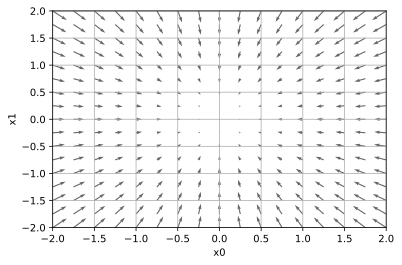

In [21]:
def numerical_gradient(f, X):
    """计算梯度矢量"""
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]).T).T
plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()

如图所示，$f(x_0,x_1)=x_0^2+x_1^2$ 的梯度呈现为有向箭头，而且：

- 所有的箭头都指向 $f(x_0,x_1)$ 的“最低处”；
- 离“最低处”越远，箭头越大。

> 实际上，梯度并非任何时候都指向最低处。
>
> 更严格讲，**梯度指示的方向是各点处的函数值减小最多的方向**。
>
> 也就是说，我们有可能在某些优化过程中只收敛到了局部最小值。

### 梯度法

机器学习的主要任务是在训练（学习）过程中寻找最优的参数。这里“最优参数”就是让损失函数取到最小值时的参数。

但是损失函数一般都很复杂（回忆一下 `XGBoost` 的损失函数推导），参数空间很庞大，我们一般不知道它在何处能取得最小值。而使用梯度来寻找函数最小值（或者尽可能小的值）的方法就是梯度法。

>再次提醒：**梯度** 表示的是各点出函数的值减小最多的方向，因此没法保证梯度所指的方向就是函数的最小值或是真正应该前进的方向。实际上在复杂的函数中，梯度指示的方向基本上都 **不是** 函数值的最小位置。

我们沿着梯度方向能够最大限度减小函数（比如损失函数）的值，因此在寻找函数的最小值的位置上还是以梯度信息为线索，决定前进的方向。

这个时候**梯度法**就起作用了。在梯度法中，函数的取值从当前位置沿着梯度方向前进一小步（配合上面的图），然后在新的地方重新求梯度，再沿着梯度方向前进，如此循环往复。

像这样，通过不断地沿着梯度方向前进，逐渐减小函数的值的过程就是**梯度法（gradient method）**，它是解决机器学习中最优化问题的常用方法。

>严格地说，寻找最小值的梯度法叫**梯度下降法**（gradient descent method），而寻找最大值的梯度法称为**梯度上升法**（gradient ascent method），注意和 **提升方法**（Boosting）相区别。

用数学式来表达梯度法，就是：

$$x_0=x_0 - \eta \frac{\partial f}{\partial x_0}$$

$$x_1=x_1 - \eta \frac{\partial f}{\partial x_1}$$

其中，$\eta$，读作 **eta**，表示更新量。回忆一下，在之前的 SKLearn 的机器学习示例中，大多都用 `eta` 作为**学习率（learning rate）**的参数，在神经网络中也是如此。学习率决定在一次学习中，应该学习多少，以及在多大程度上更新参数，就像我们走在下山路上，$\eta$ 决定了我们每一步迈多远。

上面的公式只更新了一次，我们需要反复执行，逐渐减小函数值。

$\eta$ 的具体取值不能太大或者太小，否则都没法抵达一个“合适的位置”。在神经网络中，一般会一边改变学习率的值，一般确认训练是否正常进行。

代码参考[gradient_method.py](https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch04/gradient_method.py)，用代码实现梯度下降法：

In [22]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    """
    梯度下降法
    
    f：要进行最优化的参数
    init_x：初始值
    lr：学习率，默认为0.01
    step_sum：梯度下降法重复的次数
    """
    x = init_x
    x_history = []  # 保存每一步的信息

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)  # 计算梯度矢量
        x -= lr * grad

    return x, np.array(x_history)

使用这个函数就能求得函数的极小值，如果顺利，还能求得最小值。

现在我们来求 $f(x_0,x_1)=x_0^2+x_1^2$ 的最小值：

In [23]:
init_x = np.array([-3.0, 4.0])  # 初始位置
resutl = gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)  # 执行梯度下降算法
print(resutl[0])

[-6.11110793e-10  8.14814391e-10]


最终结果是 $(-6.11110793\times10^{-10},  8.14814391\times10^{-10})$，非常接近我们已知的正确值 $(0, 0)$。所以说通过梯度下降法我们基本得到了正确的结果。

如果我们把梯度更新的图片画出，如下：

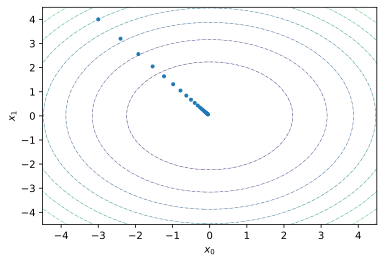

In [24]:
init_x = np.array([-3.0, 4.0])  # 初始位置
lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

step = 0.01
x_0 = np.arange(-5,5,step)
x_1 = np.arange(-5,5,step)
X, Y = np.meshgrid(x_0, x_1)  # 建立网格
Z = function_2_old(X, Y)
plt.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles='dashdot')  # 绘制等高线

plt.plot(x_history[:,0], x_history[:,1], '.')  # 绘制梯度下降过程

plt.xlim(-4.5, 4.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.show()

前面说过，**学习率**过大或者过小都无法得到好结果。

可以做实验验证一下:

In [25]:
# 学习率过大
init_x = np.array([-3.0, 4.0])  # 初始位置
lr = 10.0  # 学习率

x, x_history = gradient_descent(function_2, init_x=init_x, lr=lr, step_num=step_num)
print(x)

[-2.58983747e+13 -1.29524862e+12]


In [26]:
# 学习率过小
init_x = np.array([-3.0, 4.0])  # 初始位置
lr = 1e-10  # 学习率

x, x_history = gradient_descent(function_2, init_x=init_x, lr=lr, step_num=step_num)
print(x)

[-2.99999999  3.99999998]


由此可见：

- 学习率过大，会发散成一个很大的值；
- 学习率过小，基本上还没更新就结束了。

因此我们需要设置适当的学习率。记住，学习率是一个**超参数**，通常是人工设定的。

### 神经网络的梯度

神经网络的训练也是要求梯度的。这里的梯度指的是**损失函数**关于权重参数的梯度。比如，在[3.01 神经网络与前向传播](https://github.com/DrDavidS/basic_Machine_Learning/blob/master/深度学习基础/3.01%20神经网络与前向传播.ipynb)中，我们搭建了一个三层神经网络。其中第一层（layer1）的权重 $W$ 的形状为 $2\times3$，损失函数用 $L$ 表示。

此时梯度用 $\cfrac{\partial L}{\partial W}$ 表示。用具体的数学表达式（注意下标为了方便说明，和以前不一样）来说，就是：

$$
\large
W=
\begin{pmatrix}
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23}\\
\end{pmatrix}
$$

$$
\large
\frac{\partial L}{\partial W}=
\begin{pmatrix}
\cfrac{\partial L}{\partial w_{11}} & \cfrac{\partial L}{\partial w_{12}} & \cfrac{\partial L}{\partial w_{13}} \\
\cfrac{\partial L}{\partial w_{21}} & \cfrac{\partial L}{\partial w_{22}} & \cfrac{\partial L}{\partial w_{23}}\\
\end{pmatrix}
$$

$\cfrac{\partial L}{\partial W}$ 的元素由各个元素关于 $W$ 的偏导数构成。比如，第1行第1列的元素 $\cfrac{\partial L}{\partial w_{11}}$ 表示当 $w_{11}$ 稍微变化的时候，损失函数 $L$ 会发生多大变化。

我们以一个简单的神经网络为例子，来实现求梯度的代码：

In [102]:
import os
import sys
import numpy as np

def softmax(a):
    """定义 softmax 函数"""
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

def cross_entropy_error(y, t):
    """定义交叉熵损失函数"""
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

def numerical_gradient(f, X):
    """计算梯度矢量"""
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

class simpleNet:
    def __init__(self):
        """初始化"""
        # self.W = np.random.randn(2, 3)  # 高斯分布初始化
        self.W = np.array([[ 0.68851943, 2.06916921, -0.88125086],
                           [-1.30951576, 0.72350587, -1.88984482]])
        self.q = 1
    
    def predict(self, x):
        """预测"""
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        """损失函数"""
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

我们建立了一个名叫 `simpleNet` 的简单神经网络，其中 `softmax` 和 `cross_entropy_error` 都和以前一样。simpleNet 类只有一个实例变量，也就是形状为 $2\times 3$ 的权重参数矩阵。

网络中有两个方法，一个是前向传播 `predict`，用于预测；另一个是用于求损失函数的 `loss` 。其中参数 `x` 接受输入数据，`t`接受正确标签。

现在我们运行一下看看结果：

In [103]:
net = simpleNet()
print(net.W)  # 权重参数

[[ 0.68851943  2.06916921 -0.88125086]
 [-1.30951576  0.72350587 -1.88984482]]


In [104]:
x = np.array([0.6, 0.9])
p = net.predict(x)  # 预测
print(p)

[-0.76545253  1.89265681 -2.22961085]


In [105]:
np.argmax(p)  # 正确解（最大值）的索引

1

In [106]:
# 正确解的标签，如果是随机初始化,注意每次运行可能都不一样！！！
t = np.array([0, 1, 0])  

In [107]:
# 损失
loss1 = net.loss(x, t)
print(loss1)

0.08276656069658565


现在我们来求**梯度**。我们使用 `numerical_gradient(f, x)` 求梯度：

由于 `numerical_gradient(f, x)` 中的 `f` 是一个函数，所以为了程序兼容，我们先定义函数 `f(W)`：

In [108]:
def f(W):
    return net.loss(x, t)

In [109]:
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.03870828 -0.04766044  0.00895216]
 [ 0.05806242 -0.07149067  0.01342824]]


`numerical_gradient(f, net.W)` 的结果是 $dW$，形状是一个 $2\times 3$ 的矩阵。

观察这个矩阵，在$\cfrac{\partial L}{\partial W}$ 中：

$\cfrac{\partial L}{\partial W_{11}}$的值约为0.039，这表示如果将$w_{11}$ 增加 $h$，则损失函数的值会增加 $0.039h$。

$\cfrac{\partial L}{\partial W_{22}}$的值约为-0.071，这表示如果将$w_{22}$ 增加 $h$，则损失函数的值会减少 $0.071h$。

所以，从减少损失函数的目的出发，$w_{22}$ 应该向正方向更新，而 $w_{11}$ 应该向负方向更新。

我们求出神经网络在输入 $x=[0.6, \quad 0.9]$ 的梯度以后，只需要根据梯度法，更新权重参数即可。

手动更新试试：

In [126]:
# 学习率 lr
lr = 1e-4
print(lr)

0.0001


In [115]:
class simpleNet_step2:
    def __init__(self):
        """初始化，手动更新一次参数"""
        self.W = np.array([[ 0.68851943 - 0.0001, 2.06916921 + 0.0001, -0.88125086 - 0.0001],
                           [-1.30951576 - 0.0001, 0.72350587 + 0.0001, -1.88984482 - 0.0001]])
        self.q = 1
    
    def predict(self, x):
        """预测"""
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        """损失函数"""
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [116]:
net = simpleNet_step2()
net.W

array([[ 0.68841943,  2.06926921, -0.88135086],
       [-1.30961576,  0.72360587, -1.88994482]])

In [118]:
x = np.array([0.6, 0.9])
p = net.predict(x)  # 预测
print(p)

[-0.76560253  1.89280681 -2.22976085]


In [119]:
# 最大值为正确答案
t = np.array([0, 1, 0])  

In [122]:
# 损失
loss2 = net.loss(x, t)
print(loss2)

0.08274273376501982


In [125]:
if loss2 < loss1:
    print("loss2 比 loss1 小了：", loss1 - loss2)

loss2 比 loss1 小了： 2.3826931565829046e-05


由此可见，我们按照梯度法，更新了权重参数（步长为学习率）以后，损失函数的值下降了。

## 学习算法总结

到此，我们学习了“损失函数”、“mini-batch”、“梯度”、“梯度下降”等概念。现在回顾一些神经网络的学习步骤：

1. **minibatch**：
    
    从训练数据中**随机**选出一部分数据，这部分数据称为 mini-batch。我们的目标是减小 mini-batch 的损失函数的值。
    
    >在 PyTorch 中，使用 `torch.utils.data` 实现此功能，参考 [TORCH.UTILS.DATA](https://pytorch.org/docs/stable/data.html#multi-process-data-loading)。
    >
    >在 Tensorflow 中，使用 `tf.data` 实现此功能，参考 [tf.data: Build TensorFlow input pipelines](https://tensorflow.google.cn/guide/data)。


2. **计算梯度**：

    为了减小 mini-batch 的损失函数的值，需要求出各个权重参数的梯度。梯度表示损失函数的值减小最多的方向。


3. **更新参数**：

    将权重参数 $W$ 沿梯度方向进行微小更新。


4. **重复**：
    
    重复步骤1、步骤2、步骤3。
    

神经网络的学习大概就是按照上面4个步骤进行。这个方法通过梯度下降法更新参数。由于我们使用的数据是**随机**选择的 mini-batch 数据，所以又称为**随机梯度下降（stochastic gradient descent）**。这就是其名称由来。

在大多数深度学习框架中，随机梯度下降法一般由一个名为 **SGD** 的函数来实现：

- TensorFlow：`tf.keras.optimizers.SGD`。
- PyTorch：`torch.optim.SGD`

实际上，随机梯度下降是通过数值微分实现的，但是缺点是计算上很耗费时间，后续我们会学习**误差反向传播**法，来解决这个问题。